In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger, save_exper
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_loss_over_tsteps, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist, plot_qt_detailed_stats
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [3]:
expers_to_load = [# Meta V1 model regressionT
                  (True, "run_20170725_09_06_17_metaV1_70ep_100ops_lr1e05_adam"), 
                  (False, "run_20170730_12_21_52_metaV1_50ep_18ops_lr5e05_adam"), # 18ops
                  (False, "run_20170730_12_43_30_metaV1_50ep_32ops_lr5e05_adam"), # 32ops
                  (False, "run_20170727_16_15_37_metaV1_40ep_50ops_lr4e05_adam"), # 50ops compare with params+grads
                  (False, "run_20170727_15_57_25_metaV1_40ep_50ops_lr4e05_adam"), # with grads+params as input
                  # Meta V3.2 model - fixed constant weights 1/T
                  (False, "run_20170728_15_36_57_metaV3.2_80ep_100ops_lr5e06_adam"),
                  # Meta V3.1 model - fixed geometric weights
                  (False, "run_20170724_13_47_44_metaV3.1_50ep_100ops_lr5e06_adam"), # nu=0.1
                  (False, "run_20170724_13_16_09_metaV3.1_50ep_100ops_lr5e06_adam"), # nu=0.3
                  (False, "run_20170724_12_01_19_metaV3.1_50ep_100ops_lr5e06_adam"), # nu=0.6
                  (False, "run_20170724_11_24_01_metaV3.1_50ep_100ops_lr5e06_adam"), # nu=0.9
                  # Act V2 model - FIXED HORIZON
                  (False, "run_20170724_21_56_14_actV2_70ep_100ops_lr5e05_adam"), # nu=0.1
                  (False, "run_20170724_20_13_19_actV2_70ep_100ops_lr5e05_adam"), # nu=0.3 
                  (False, "run_20170724_20_06_17_actV2_70ep_100ops_lr5e05_adam"), # nu=0.6
                  (False, "run_20170730_11_31_54_actV2_100ep_100ops_lr5e05_adam"), # nu=0.9
                  (False, "run_20170730_16_21_38_actV2_100ep_18ops_lr5e05_adam"), # nu=0.9 and 18ops fixed
                  (False, "run_20170730_15_40_46_actV2_100ep_32ops_lr5e05_adam"), # nu=0.9 and 32ops fixed
                  # ACT V2 model - stochastic horizon - 18 opt steps
                  (False, "run_20170725_11_47_16_actV2_70ep_18ops_lr4e05_adam"), # nu=0.1
                  (False, "run_20170725_11_37_00_actV2_70ep_18ops_lr4e05_adam"), # nu=0.3
                  (False, "run_20170725_13_03_53_actV2_90ep_18ops_lr4e05_adam"), # nu=0.6
                  (False, "run_20170728_14_25_25_actV2_100ep_18ops_lr4e05_adam"), # nu=0.9
                  # ACT V2 model - stochastic horizon - 32 opt steps
                  (False, "run_20170724_22_55_12_actV2_70ep_32ops_lr5e05_adam"), # nu=0.1
                  (False, "run_20170724_17_23_35_actV2_70ep_32ops_lr5e05_adam"), # nu=0.3
                  (False, "run_20170724_17_46_16_actV2_70ep_32ops_lr5e05_adam"), # nu=0.6
                  (False, "run_20170725_08_41_02_actV2_70ep_32ops_lr5e05_adam")] # nu=0.9


In [4]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_regression_T_100ops / run_20170725_09_06_17_metaV1_70ep_100ops_lr1e05_adam


INFO - INFO - loaded existing model from file logs/run_20170725_09_06_17_metaV1_70ep_100ops_lr1e05_adam/metaV1_regression_T_100ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']


In [9]:
del new_experiments
new_experiments = []

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(get_experiment(path_to_exp=exper[1] + "/" + "exp_statistics_test10000.dll",
                                              full_path=True))
print("Ready")

Ready


In [4]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


[ 13.71080058  13.71058094  13.70854353  13.70820345  13.70719283
  13.70794892  13.70668132  13.70599108  13.70478217  13.70382084
  13.70372197  13.70317328  13.70304711  13.70238166  13.70157955
  13.7005314   13.69870363  13.69855403  13.6982764   13.69701368
  13.69780311  13.6965506   13.69610813  13.69468351  13.69330954
  13.69376252  13.6928099   13.69207141  13.69157864  13.69074564]


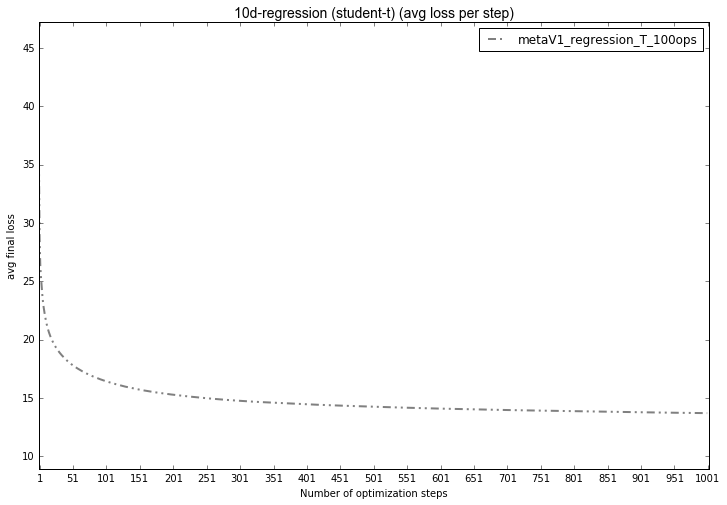

In [12]:
# new_exp_only = [new_experiments[0], new_experiments[4], new_experiments[8], new_experiments[12]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10regT_actV2_effect_stochastic_learning_20ops", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=1000,
                                              sort_exper="10d-regression (student-t)",
                                              log_scale=False,
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170730_11_31_54_actV2_100ep_100ops_lr5e05_adam/loss_optimizer_actV2_100ep_100ops_14:50:03.png


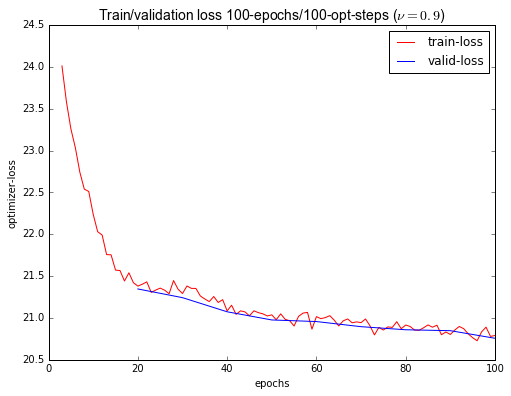

In [7]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [3]:
val_funcs = RegressionFunction(n_funcs=15000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_15000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
            val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [87]:
with open("data/val_funcs_20000_10_1.0_10.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [2]:
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [6]:
print(len(new_experiments))
exp_idx = 1
max_steps = 1000
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, save_run="test10000")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model actV2_regression_T_32ops with 10000 functions


3
Validating model actV2_regression_T_32ops with q-prob 0.600


RuntimeError: cuda runtime error (2) : out of memory at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66

('Key ', 100)
INFO - Successfully saved fig logs/run_20170730_16_21_38_actV2_100ep_18ops_lr5e05_adam/qt_T_dist_val_actV2_100ep_18ops.png


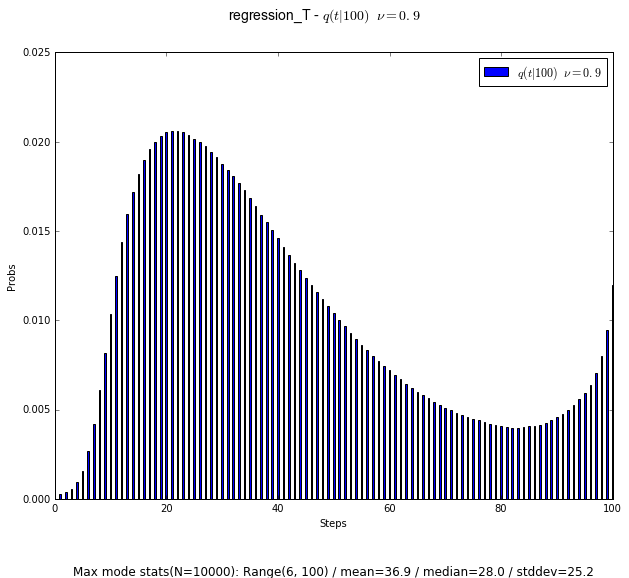

In [6]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)


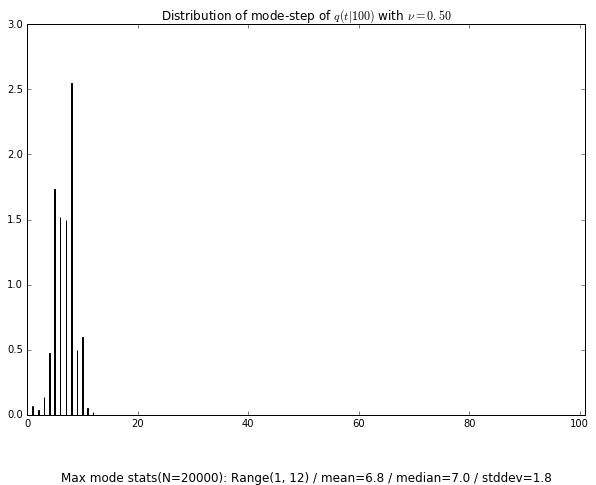

In [23]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


Run with key 100
INFO - Successfully saved fig logs/run_20170728_14_25_25_actV2_100ep_18ops_lr4e05_adam/qt_detailed_stats_actV2_100ep_18ops_td0.90.png


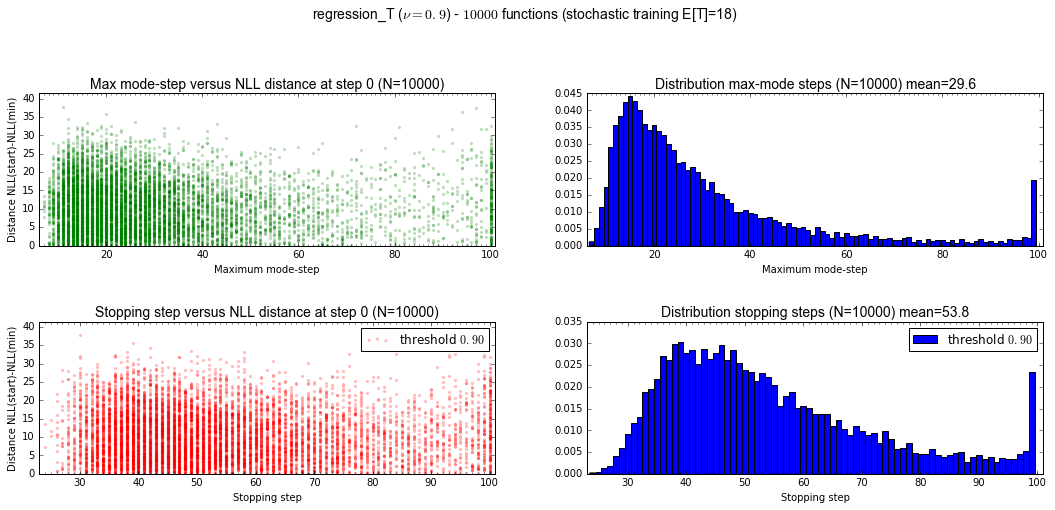

In [7]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [19]:
rosenbrockfunction = lambda x,y: (3.5-x)**2+100*(y-x**2)**2

fig = plt.figure(figsize=(8, 6))
n = 100 # number of discretization points along the x-axis
m = 100 # number of discretization points along the x-axis
a=-2.5; b=4 # extreme points in the x-axis
c=8; d=10 # extreme points in the y-axis

X,Y = np.meshgrid(np.linspace(a,b,n), np.linspace(c,d,m))

Z = rosenbrockfunction(X,Y)

plt.contour(X,Y,Z,np.logspace(-0.5,3.5,20,base=10),cmap='gray')
plt.title(r'$\textrm{Rosenbrock Function: } f(x,y)=(1-x)^2+100(y-x^2)^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.show()


/home/jogi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: covariance is not positive-semidefinite.


<IPython.core.display.Javascript object>


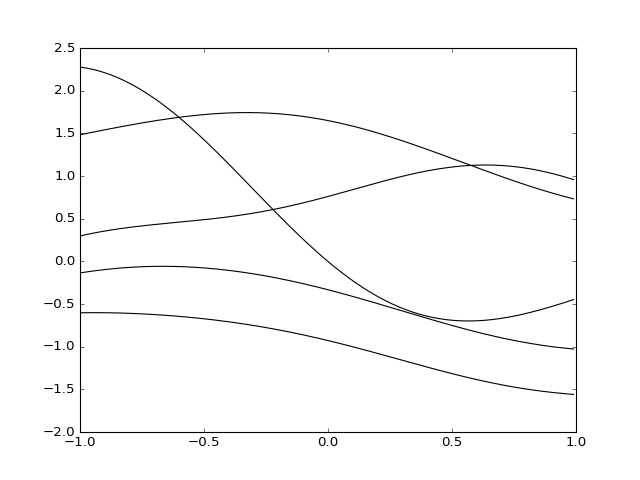

In [10]:
#!/usr/bin/python

from math import exp


def rbf_kernel(x1, x2, variance = 1):
    return exp(-1 * ((x1-x2) ** 2) / (2*variance))

def gram_matrix(xs):
    return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

xs = np.arange(-1, 1, 0.01)
mean = [0 for x in xs]
gram = gram_matrix(xs)

plt_vals = []
for i in range(0, 5):
    ys = np.random.multivariate_normal(mean, gram)
    plt_vals.extend([xs, ys, "k"])
plt.plot(*plt_vals)
plt.show()

In [ ]:
expers_to_load = [# Meta V3 model regression
                  (True, "run_20170713_17_03_57_metaV1_10ep_100ops_retrain_lr1e04_adam"), # weights=1
                  (True, "run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam"),  # nu=0.3, 10 epochs
                  (True, "run_20170714_10_28_31_metaV3.1_10ep_100ops_lr1e04_adam"), # nu=0.5, 10 epochs
                  (True, "run_20170713_17_16_28_metaV3.1_16ep_100ops_lr1e04_adam"), # nu=0.7, 14 epochs
                  (True, "run_20170713_17_15_05_metaV3.1_16ep_100ops_lr1e04_adam"), # nu=0.9, 16 epochs
                  (True, "run_20170713_16_39_30_metaV3.2_10ep_100ops_retrain_lr1e04_adam")] # uniform, 12 epochs